In [15]:
import os
import sys
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

src_dir = os.path.join("src")
sys.path.insert(0, src_dir)
from trainer import VideoTrainer
from utils import init, DotDict
from parse_config import ConfigParser

In [2]:
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

In [3]:
args = DotDict({
    "resume": "saved/0724_073519/model_best"
})
config = ConfigParser.from_args(args)
update(config.config, {
    "data_loader":{
        "args": {
            "data_path": "data/orig-front-videos",
            "validation_split": 0.333,
            "shuffle": True
        }
    }
})
data_loader, model = init(config)

2021-07-24 15:22:30.488725: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The following Variables were used a Lambda layer's call (tf.nn.convolution), but
are not present in its tracked objects:
  <tf.Variable 'stem_conv/kernel:0' shape=(3, 3, 3, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'stem_bn/gamma:0' shape=(32,) dtype=float32>
  <tf.Variable 'stem_bn/beta:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d), but
are not present in its tracked objects:
  <tf.Variable 'block1a

In [4]:
trainer = VideoTrainer(model, config, data_loader=data_loader)

In [5]:
results, logit, gTruth = trainer.test()

  0%|          | 0/342 [00:00<?, ?it/s]2021-07-24 15:22:45.236332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly
 (repeated 152 more times)
Loss: 0.063:   1%|          | 3/342 [00:11<19:47,  3.50s/it]deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly
 (repeated 153 more times)
deprecated pixel format used, make sure you did set range correctly
Loss: 0.047:   1%|          | 4/342 [00:16<22:23,  3.98s/it]deprecated pixel format used, make sure you did set range correctly
 (repeated 152 more times)
Loss: 0.037:   2%|▏         | 6/342 [00:23<20:39,  3.69s/it]deprecated pixel format used, make sure you did set range correctly
 (repeated 153 more times)
deprecated pixel format used, make sure y

In [6]:
results

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.051178657>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9824732>}

In [7]:
arr_pred = list(map(lambda x: list(x.numpy().argmax(-1)), logit))
arr_pred = [item for sublist in arr_pred for item in sublist]

In [8]:
arr_truth = list(map(lambda x: list(x.numpy()), gTruth))
arr_truth = [item for sublist in arr_truth for item in sublist]

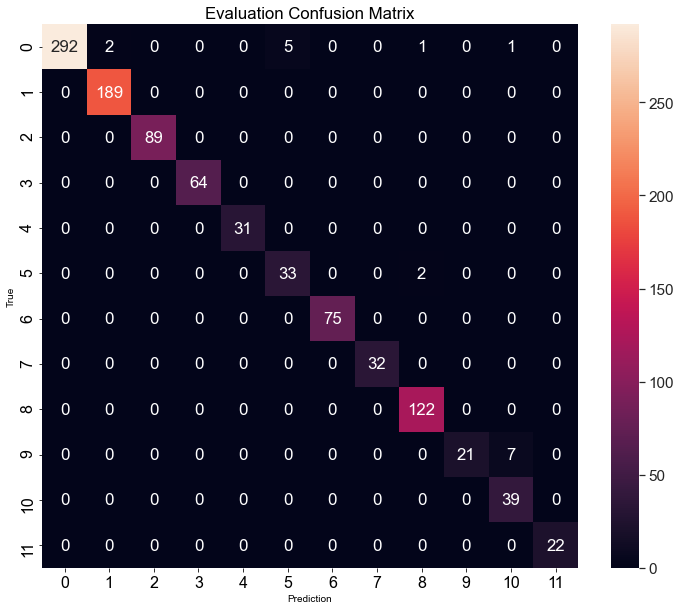

In [9]:
fig, ax = plt.subplots(figsize=[12, 10])
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(arr_truth, arr_pred), annot=True, ax=ax, fmt='.20g')
plt.title("Evaluation Confusion Matrix")
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
plt.xticks(ticks=[k + 0.5 for k in range(12)], fontsize = 16)
plt.yticks(ticks=[k + 0.5 for k in range(12)], fontsize = 16)
plt.savefig("confusion_matrix.svg")

In [10]:
oh_truth = label_binarize(np.asarray(arr_truth), classes=np.arange(16))
print(oh_truth.shape)
oh_truth

(1027, 16)


array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
y_score = list(map(lambda x: x.numpy(), logit))
y_score = [item for sublist in y_score for item in sublist]
y_score = np.asarray(y_score)
y_score.shape

(1027, 16)

In [12]:
# Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(12):
    fpr[i], tpr[i], _ = roc_curve(oh_truth[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [13]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(oh_truth.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(12)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(12):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 12

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

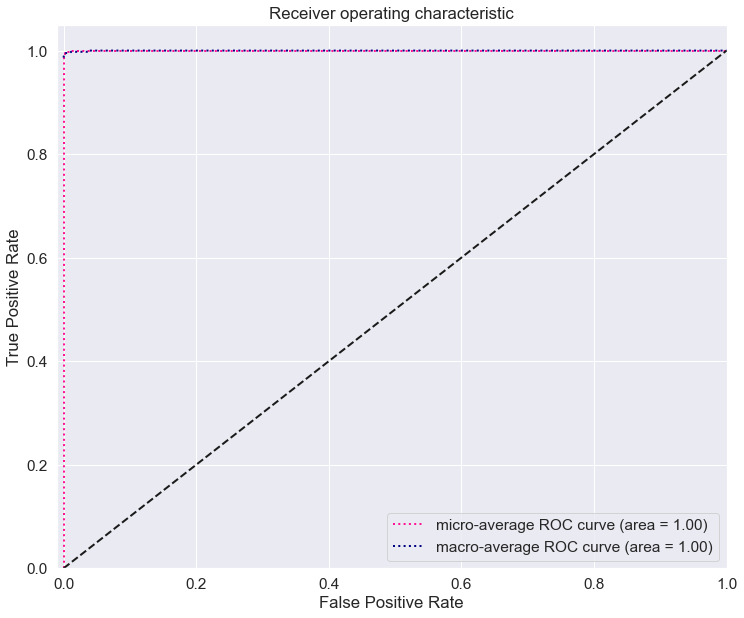

In [14]:
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(12), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [17]:
classes = {
    "Unknown": 0,
    "LookScreen": 1,
    "LookDown": 2,
    "LookSide": 3,
    "LookBack": 4,
    "Leave": 5,
    "Speaking": 6,
    "LookUp": 7,
    "UsePhone": 8,
    "Scratching": 9,
    "Drinking": 10,
    "Typing": 11,
    "Unused-0": 12,
    "Unused-1": 13,
    "Unused-2": 14,
    "Unused-3": 15
}

In [20]:
print(classification_report(np.asarray(arr_truth), np.asarray(arr_pred), target_names=list(classes.keys())[:12]))

              precision    recall  f1-score   support

     Unknown       1.00      0.97      0.98       301
  LookScreen       0.99      1.00      0.99       189
    LookDown       1.00      1.00      1.00        89
    LookSide       1.00      1.00      1.00        64
    LookBack       1.00      1.00      1.00        31
       Leave       0.87      0.94      0.90        35
    Speaking       1.00      1.00      1.00        75
      LookUp       1.00      1.00      1.00        32
    UsePhone       0.98      1.00      0.99       122
  Scratching       1.00      0.75      0.86        28
    Drinking       0.83      1.00      0.91        39
      Typing       1.00      1.00      1.00        22

    accuracy                           0.98      1027
   macro avg       0.97      0.97      0.97      1027
weighted avg       0.98      0.98      0.98      1027

